TODO:
- Track a discrete approximation of our cost integral within the loop and then compare how well different control policies do
- Instead of always "sleeping if baby is asleep" implement an optimal control iteration or forward-backward sweep algorithm (I looked it up). Then we could revise u_control based on costate information or a direct search approach
- Using dt=1 hour is just for demonstration. We can reduce it to 0.5 or 0.25 hours for more granularity. Just make sure we're consistent with defintiions of Dp and Np when we sum up continuous intervals

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import solve_bvp

Globals and Helpers

In [8]:
# We'll store baby sleep states and parent sleep states over time (discretized).
# We'll track "epsilon" variations cumulatively

total_eps = 0.0    # For tracking baby state randomness
sleep_tracker = [] # For storing the parent's sleep/awake state at each time step

def eps_tracker(eps):
    """
    Accumulate the random perturbation (eps) to model unpredictability.
    We'll treat 'eps' as a single float, or an array chunk, 
    then return the updated total.
    """
    global total_eps
    total_eps += eps
    return total_eps

def parent_sleep_tracker(val):
    """
    Append the parent's sleep/awake state for the current time step.
    """
    global sleep_tracker
    sleep_tracker.append(val)
    return sleep_tracker

Modeling Functions

In [9]:
def delta(t):
    """
    Weighted coefficient for night vs. day:
      - 0.9 if 0 < t < 8 (Night)
      - 0.1 if 8 <= t <= 24 (Day)
    """
    if 0 < t < 8:
        return 0.9
    elif 8 <= t <= 24:
        return 0.1
    # Return something default if out of range:
    return 0.1

def B(t, eps):
    """
    Baby sleep state: 1 = baby asleep, 0 = baby awake.
    We incorporate an epsilon shift in t for unpredictability.
    
    we pass in a single eps or an array-based shift for discrete steps.

    We'll do a piecewise approach:
    - For 0..3 hours, baby is asleep (B=1).
    - For 3..4 hours, baby is awake (B=0).
    Then repeat every 4 hours with a shift by eps.
    """
    # Combine time with the epsilon shift:
    t_adj = t - eps  # Shift time by eps

    # Find a 4-hour block in which t_adj belongs:
    # We'll do mod 4 so it repeats:
    mod_block = t_adj % 4  # remainder in [0, 4)

    # If mod_block < 3 => baby asleep, else baby awake
    if 0 <= mod_block < 3:
        return 1
    else:
        return 0

def w(t):
    """
    Placeholder function: Work or childcare obligations at time t.
    """
    return 0

def u_control(t, baby_state):
    """
    The parent's control: 1 = parent chooses to sleep, 0 = parent chooses to be awake.
    This is where we can try our "optimal control" strategies or test strategies
    
    For now, the naive policy: 
    'Parent tries to sleep if baby is asleep (B=1) and it's night.'
    """
    if baby_state == 0:
        return 0  # Must be awake if baby is awake
    else:
        # baby is asleep => choose whether to sleep:
        if delta(t) > 0.5:
            # It's 'night': definitely sleep
            return 1
        else:
            # It's 'day': maybe partial logic, but let's just say sleep anyway
            return 1

Derived Quantities

In [10]:
def Dp(time_index):
    """
    Return the parent's uninterrupted sleep duration at discrete time step 'time_index'.
    We look backward in 'sleep_tracker' until we hit an awake state (0) or start of array.
    """
    if sleep_tracker[time_index] == 0:
        return 0
    # Accumulate how many consecutive steps of '1' up to time_index
    dur = 0
    for i in range(time_index, -1, -1):  # walk backward
        if sleep_tracker[i] == 1:
            dur += 1
        else:
            break
    return dur  # in discrete steps (hours, if dt=1)

def Np(time_index):
    """
    Return the number of distinct 'sleep intervals' from t0 up to time_index.
    We'll increment count each time we see a 0->1 transition in sleep_tracker.
    """
    if time_index < 0:
        return 0
    num_naps = 0
    for i in range(1, time_index+1):
        if sleep_tracker[i] == 1 and sleep_tracker[i-1] == 0:
            num_naps += 1
    return num_naps

Discrete Simulation

In [11]:
def simulate_day(dt=1, T=24):
    """
    Discrete simulation from t=0..T with step dt.
    We'll incorporate random eps for each step to shift baby's sleep block slightly.
    """
    global sleep_tracker, total_eps
    sleep_tracker = []
    total_eps = 0.0

    # Create a time array from 0..T in increments dt
    t_vals = np.arange(0, T+1e-9, dt)
    # For each step, draw a random shift in epsilon:
    eps_shifts = np.random.uniform(-0.5, 0.5, size=len(t_vals))

    baby_states = []  # For storing baby state
    parent_states = [] # For storing parent's chosen control
    dp_vals = []
    np_vals = []

    for i, t in enumerate(t_vals):
        # Accumulate epsilon:
        e = eps_tracker(eps_shifts[i])
        # baby state:
        b_state = B(t, e)
        baby_states.append(b_state)

        # parent's control 
        u_val = u_control(t, b_state)
        parent_sleep_tracker(u_val)
        parent_states.append(u_val)

        # now that we have updated sleep_tracker, we can compute Dp, Np:
        dp_vals.append(Dp(i))
        np_vals.append(Np(i))

    return t_vals, baby_states, parent_states, dp_vals, np_vals

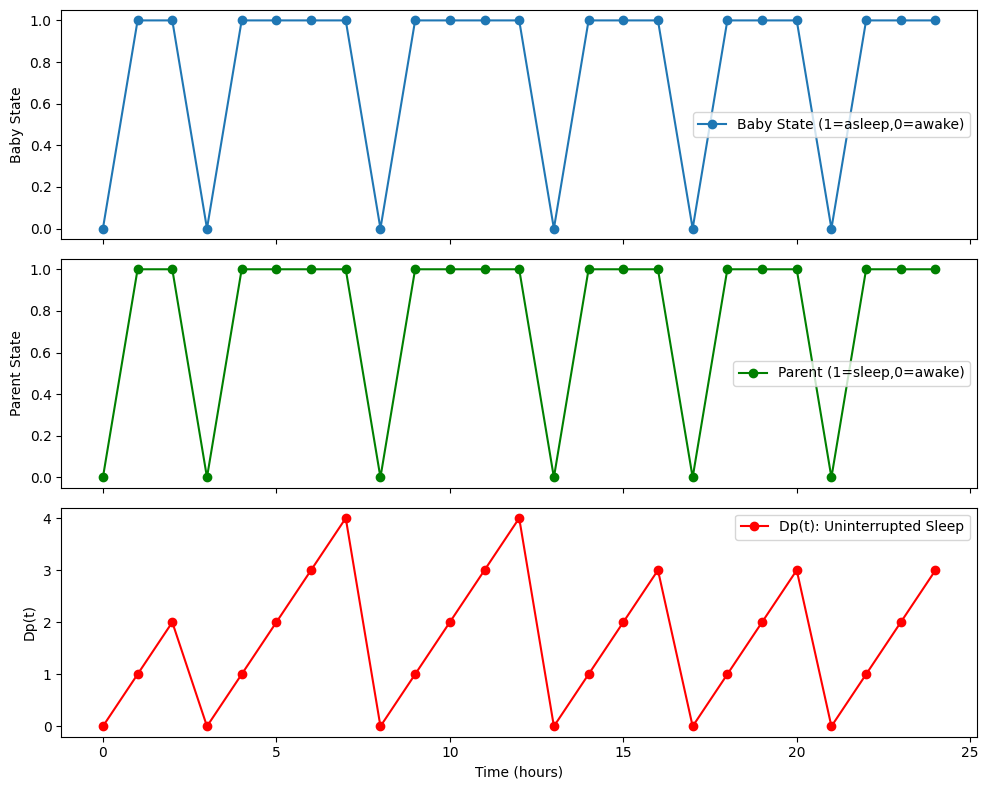

In [12]:
t_vals, baby, parent, dp_vals, np_vals = simulate_day(dt=1, T=24)

# Plot results
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

ax[0].plot(t_vals, baby, marker='o', label='Baby State (1=asleep,0=awake)')
ax[0].set_ylabel('Baby State')
ax[0].legend()

ax[1].plot(t_vals, parent, marker='o', color='g', label='Parent (1=sleep,0=awake)')
ax[1].set_ylabel('Parent State')
ax[1].legend()

ax[2].plot(t_vals, dp_vals, marker='o', color='r', label='Dp(t): Uninterrupted Sleep')
ax[2].set_ylabel('Dp(t)')
ax[2].set_xlabel('Time (hours)')
ax[2].legend()

plt.tight_layout()
plt.show()